# <tt>synphot</tt>: Predicting photometric magnitudes with an empirical spectrum

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using `astropy.coordinates.Skycoord`, `astroquery.sdss`, and `tynt`</li>
<li>Download a spectrum and construct a source spectrum object using `synphot.SourceSpectrum`</li>
<li>Simulate bandpass throughput with `synphot.SpectralElement`</li>
<li>Simulate the photometric observation with `synphot.Observation`</li>
<li>Compute the expected magnitudes from this observation with `synphot`'s `effstim()` function
</ul>

## Keywords
synphot, synthetic photometry, tynt, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#phoenix">Get the observed spectrum of our target from SDSS</a></li>
<li><a href="#source_spectrum">Construct a source spectrum object</a></li>
<li><a href="#bandpass">Create the bandpasses of observation</a></li>
<li><a href="#observation">Combine the spectrum with the bandpass throughput and "observe"</a></li>
<li><a href="#counts">Compute the magnitudes in each band</a></li>
<li><a href="#compare">Compare simulated magnitudes to observed magnitudes</a></li>
</ol>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Select an observed spectrum with a strong Halpha emission line from SDSS

In this example we choose the galaxy <a href="https://skyserver.sdss.org/dr12/en/tools/explore/Summary.aspx?id=1237662301903192106" target="_blank">IRAS F15163+4255 NW</a>.

Set the coordinates for the object:

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord

ra = 229.525575754 * u.degree
dec = 42.745853761 * u.degree
coords = SkyCoord(ra, dec)

Retrieve the observed spectrum from SDSS:

In [3]:
from astroquery.sdss import SDSS
from synphot import units

spectrum_fits = SDSS.get_spectra(coordinates=coords)
data = spectrum_fits[0][1].data

wavelengths = 10 ** data['loglam'] * u.angstrom
flux = data['flux'] * 1e-17 * units.FLAM  # units are given in 10^-17 ergs/s/cm^2/AA

/Users/tiffanyjansen/anaconda3/lib/python3.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "
/Users/tiffanyjansen/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


### Construct a `synphot` source spectrum object from the empirical spectrum:

Make the source spectrum object with <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">SourceSpectrum</a>:

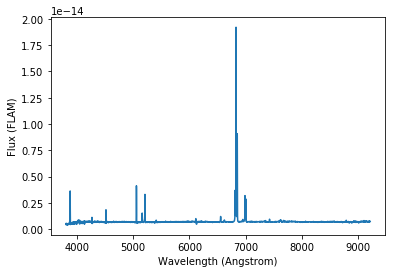

In [4]:
from synphot.spectrum import SourceSpectrum
from synphot.models import Empirical1D

spectrum = SourceSpectrum(Empirical1D,
                          points=wavelengths, lookup_table=flux)

spectrum.plot(flux_unit='FLAM')

### Model the bandpasses

We query the SDSS filter transmission functions from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a> using the <a href="https://tynt.readthedocs.io/en/latest/index.html">tynt</a> package. These transmission functions include the effect of the CCD's quantum efficiency on the spectrum.

To construct a bandpass from an array with `synphot`, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a> with the Empirical1D model:

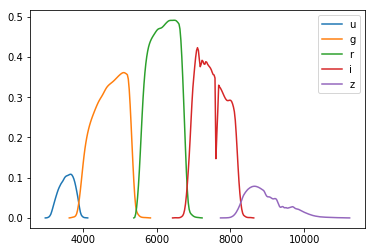

In [5]:
import tynt
from synphot.spectrum import SpectralElement

sdss_bands = ['u', 'g', 'r', 'i', 'z']

f = tynt.FilterGenerator()

bandpasses = {}
for band in sdss_bands:
    filt = f.download_true_transmittance('SLOAN/SDSS.' + band)
    bp = SpectralElement(Empirical1D,
                         points=filt.wavelength,
                         lookup_table=filt.transmittance)
    # for boxy bandpasses, tapering them with taper() is recommended
    bandpasses[band] = bp.taper()

    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='upper right')
plt.show()


You can also construct a bandpass from a file using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement.from_file">SpectralElement.from_file()</a>

Once we have all of the effects on the source spectrum set, we can combine them together by simply multiplying the SpectralElement objects:

### Model the observation

In [21]:
from synphot.observation import Observation

# zero point flux of sdss system
zero_point_star_equiv = u.zero_point_flux(3631.1 * u.Jy)

fluxs = {}
for band in sdss_bands:
    observation = Observation(spectrum, bandpasses[band], force='taper')
    flux = observation.effstim('Jy')
    fluxs[band] = flux.to(u.nanomaggy, zero_point_star_equiv)

# # SDSS mags aren't exactly equal to AB mags. Apply corrections
# mags['u'] += 0.04
# mags['z'] -= 0.02

In [22]:
for band in sdss_bands:
    print(band + ' =', np.round(fluxs[band], 5))

u = 8.98588 nmgy
g = 144.40355 nmgy
r = 256.01483 nmgy
i = 397.2675 nmgy
z = 362.74829 nmgy


### Compare the u,g,r,i,z empirical magnitudes to what we predict with synphot

Get the magnitudes measured by the SDSS fibers

In [45]:
model_flux = ['fiberFlux_' + band for band in sdss_bands]
flux_table = SDSS.query_crossid(coordinates = coords, photoobj_fields=model_flux)
sdss_fluxs = {}
for band in sdss_bands:
    # sdss fluxes are given in units of "nanomaggies"
    sdss_fluxs[band] = flux_table['fiberFlux_' + band] * u.nanomaggy

In [46]:
sdss_fluxs

{'u': <Quantity [42.2234] nmgy>,
 'g': <Quantity [110.8969] nmgy>,
 'r': <Quantity [190.9089] nmgy>,
 'i': <Quantity [294.157] nmgy>,
 'z': <Quantity [413.4377] nmgy>}

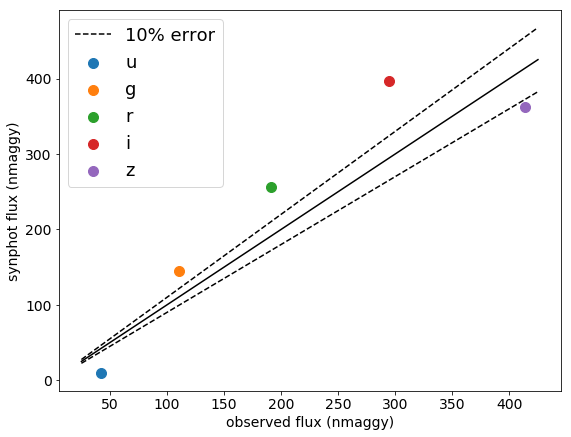

In [52]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(9, 7))

for band in sdss_bands:
    plt.scatter(sdss_fluxs[band], fluxs[band],
                s=100, label=band)

# one-to-one line
magrange = np.linspace(25, 425, 10)
plt.plot(magrange, magrange, color='black')
plt.plot(magrange, magrange * 0.9, color='black', ls='--', label='10% error')
plt.plot(magrange, magrange * 1.1, color='black', ls='--')

plt.ylabel('synphot flux (nmaggy)', size='14')
plt.xlabel('observed flux (nmaggy)', size='14')

# plt.xlim(19, 15)
# plt.ylim(20.5, 15)

plt.legend(prop={'size': 18})